# CLIM 614 -- Homework #1
This homework assignment consists of three separate sections:

* __A. Conduction__
    * Using the example of heat flux across an interface, examine how conductivity, heat capacity and heat sources affect temperature.
* __B. Extinction__
    * What does extinction of a quantity look like, and how do parameter choices affect it?
* __C. Sensitivity & Correlation__
    * How strongly do changes in one quantity depend on changes in another? What are the implications for coupling and feedbacks?

**As always, feel free to tinker!**

-------------

In this assignment and several of the subsequent assignments, we will be using the [**MetPy**](https://unidata.github.io/MetPy/latest/index.html) package. It is a library of Python functions for reading, visualizing, and performing calculations with weather data. One of the features of **MetPy** is that it uses [**Pint**](https://pint.readthedocs.io/en/stable/), which assigns units to variables and arrays. Thus, **MetPy** will raise an error any time units do not agree, which can be tedious but is an excellent way to ensure calculations are done correctly and bugs are discovered. Units are assigned to a variable or array by multiplying it by the `units` function with the appropriate argument:

`freezing = 273.15 * units.K` 

or

`freezing = 273.15 * units('K')`

One nice feature is that it will sort out mixed mode units as long as the dimensions agree. For example, `1*units('cm') + 1*units('inch')` will return 3.54 cm, but `1*units('cm') + 1*units('minute')` will raise an error.

The list of valid units and their abbreviations can be found in the **Pint** [definitions file](https://github.com/hgrecco/pint/blob/master/pint/default_en.txt).

In [1]:
# Import useful software packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.constants as c
from metpy.units import units

# Set some universal parameters
seconds_per_day = 86400
days_per_year = 365

--------------------
## A. Conduction

Conduction is a transfer or flux down gradient within a matrix of matter, from high to low values. 

$$q = -k \frac{dS}{dz}$$

* $q$ is the flux - a measure of the rate of conduction.
* $S$ can be any state variable, e.g., temperature.
* $k$ is a *conductivity*, one of two factors that determines how quickly conductions occurs. It governs the magnitude of the flux, and is usually tied to properties of the *matrix of matter*.
* $z$ is a unit distance in the direction of the net flux. Fluxes may be going on in all directions, but summed up there will be predominant direction, a vector of the flow. 

$\frac{dS}{dz}$ defines a *gradient* of $S$ in the $z$ direction, which is the other factor determining the rate of conduction. Conduction is proportional to the magnitude of the gradient.

Note: the reciprocal of a *conductivity* or *conductance* is a *resistance*: $r=1/k$. Depending on the application you may see either, or both, terms used.  

### A.1 Heat flux
The code cell below shows how heat flux changes depending on the teperature gradient.

Text(0.5, 0, 'Temperature gradient [kelvin]')

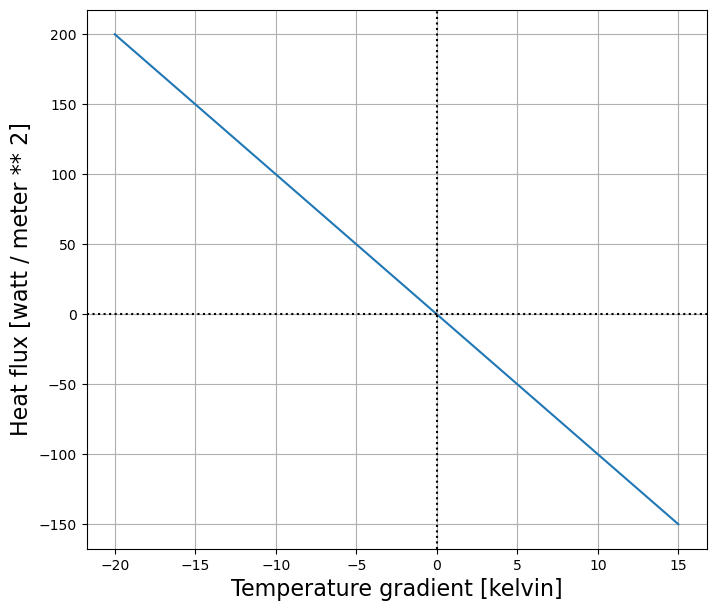

In [17]:
#########################################################
#########################################################
### Parameters for this exercise:
# Two temperatures. We'll set T2 to span a range...
T1 = 295.0 * units.degree_Kelvin
T2 = np.arange(275.0, 310.1, 1.0) * units.K
# Distance between the location of the centers of mass represented by T1 and T2
dz = 10 * units.cm
# Conductivity
k  = 1.0 * units.watts / units.m / units.K

plot_scale = 1.0 # <<<< Plot scale (to easiy make your figure bigger or smaller)
#########################################################
#########################################################

# A simple function to define a conduction
def heat_flux(conductivity, distance, temperature1, temperature2):
    return - conductivity * (temperature2 - temperature1) / distance

q = heat_flux(k, dz, T1, T2) # Notice: the function can handle the fact that T2 is a series
q = q.to('W/m^2') # Convert to the units we expect, otherwise it gives us W/m/cm

# Plot the function
fig = plt.figure(figsize = (plot_scale*8, plot_scale*7))
plt.plot(T2-T1, q) # Temperature difference on x-axis, heat flux on y-axis
plt.grid()
plt.axhline(y=0, ls=":", c="k")
plt.axvline(x=0, ls=":", c="k")
plt.ylabel("Heat flux ["+str(q.to('W/m^2')[0].units)+"]", fontsize=16)
plt.xlabel("Temperature gradient ["+str(T1.units)+"]", fontsize=16)

### A2. Heat fluxes change temperatures

A flux of heat over time will change the temperatures. The rate of change of temperature depends on the *heat capacity* of the substance. The larger the heat capacity, the more energy it takes to change its temperature by 1˚.

Here we will make a simple model of heat conduction between two blocks in contact with each other, where the *prognostic variables* will be the two temperatures. We will run this model forward in time from a pair of starting temperatures at time $t=0$.

In [48]:
#########################################################
#########################################################
### Parameters for this exercise
# Two initial temperatures:
T1 = 295.0 * units.K
T2 = 310.0 * units.K

# Distance between the location of the centers of mass represented by T1 and T2:
dz = 0.1 * units.m

# Conductivity
k  = 2.5 * units.watts / units.m / units.K

# Heat capacity and mass of each block (set to be the same for each)
c_m = 700 * units("J/K/kg")
mass = 100 * units.kg

# Surface area over which the two blocks are in contact
unit_area = 1.0 * units("m^2")

# Time step of our model, and how many steps to run (default is 10 seconds and 2 hours)
time_interval = 10 * units.sec
timesteps = 720

# Plot scale (to make your figure bigger or smaller)
plot_scale = 1.0
#########################################################
#########################################################
 
# A function to define temperature change given mass, heat flux and heat capacity
def temperature_change(heat_capacity, mass, heat_flux):
    return heat_flux / heat_capacity / mass

# Make empty series to hold the output of our model: 
series_q = np.full(timesteps, np.nan) * units('W/m^2')
series_T1 = np.full(timesteps+1, T1) * units.K
series_T2 = np.full(timesteps+1, T2) * units.K
series_time = np.full(timesteps+1, 0.0) * units('minute')

# This is the time loop for the model: 
for t in range(timesteps):
    series_q[t] = heat_flux(k, dz, series_T2[t], series_T1[t])
    del_t = temperature_change(c_m, mass, series_q[t])
    series_T1[t+1] = series_T1[t] + del_t * time_interval * unit_area
    series_T2[t+1] = series_T2[t] - del_t * time_interval * unit_area
    series_time[t+1] = (t+1) * time_interval
    # print (t, series_q[t], del_t) # Uncomment this if you want - it runs so fast though...

#### Plot the results as time series during the course of the model run.

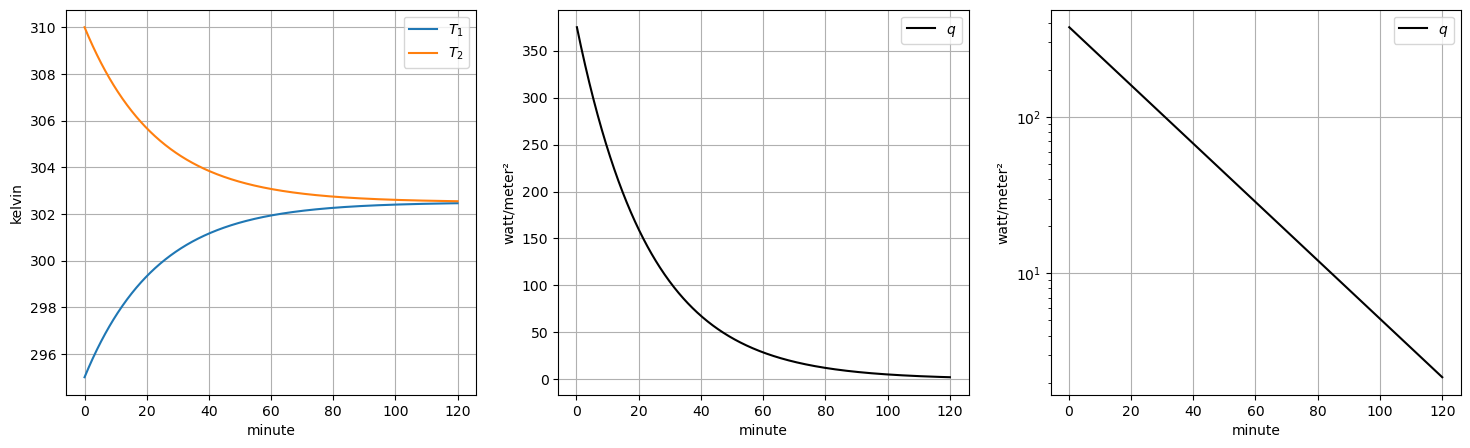

In [49]:
# Setting up a 3-panel plot - each "ax" is a panel
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(plot_scale*18, plot_scale*5))

# Left panel
ax1.plot(series_time, series_T1)  # Temperature 1
ax1.plot(series_time, series_T2)  # Temperature 2
ax1.grid()
ax1.legend(["$T_1$", "$T_2$"])

# Middle panel
ax2.plot(series_time[1:], series_q, "k-") # Heat flux
ax2.grid()
ax2.legend(["$q$"])

# Right panel
ax3.plot(series_time[1:], series_q, "k-") # As in the middle panel...
ax3.set_yscale("log")                     # ...but using a log scale on the y-axis
ax3.grid()
ax3.legend(["$q$"])


### Answer some questions
In the cell below, write your answers to these questions.
1. In A1, you see that the rate of heat flux is *linearly dependent* on the temperature gradient. Try different values for the conductivity $k$. What is the dependence of heat flux on the value of the conductivity? Is it also linear?
2. In A2, you see the temperatures converge over time in the left plot. Try increasing and decreasing each of conductivity, heat capacity, mass, and surface area (one at a time). Comment on how each affects the rate at which temperatures converge.
3. In the middle plot of A2, you see the heat flux $q$ declines as the temperature gradient does, consistent with what you saw in A1. But both drop in a non-linear fashion. The right plot shows the change in $q$ over time as a straight line, because the y-axis is scaled differently. Describe what this tells us.

### Answers

1. Changing the value of $k$ changes the _magnitude_ of the heat flux. The relationship is technically linear, since $k$ is a constant value and the heat flux changes at a constant rate for any value of $k$, resulting in a vertical line when $k$ is plotted on the x-axis. The scale of the y-axis (heat flux) ranges from -300 to 400 when $k$ = 2.0, and from -3000 to 4000 when $k$ = 20.0. 

2. 
- Increasing conductivity from 2.5 to 20 W/m/K: The temperatures converge much more quickly, at around 15 minutes.
- Decreasing conductivity from 2.5 to 0.5 W/m/K: The temperatures don't converge at all within the 120 minutes plotted, though they get within about 5 K of each other ($T_2$ at about 305 K and $T_1$ at about 300 K at 120 minutes).
- Increasing heat capacity from 700 to 1000 J/K/kg: The temperature graph looks similar to the initial conditions (at c = 700), but the temperatures don't fully converge by 120 minutes (they are within about 1 K of each other though). 
- Decreasing heat capacity from 700 to 300 J/K/kg: The temperatures converge at about 50 minutes, which makes sense as 300 is slightly less than half of 700, so the rate of convergence should be slightly less than half of the original rate (where they converge at 120 minutes). 
- Increasing mass from 100 to 1000 $kg$: Similar to decreasing conductivity, the temperatures don't converge within the 120 minutes plotted and they are further from each other than the lower conductivity run ($T_2$ at about 307 K and $T_1$ at about 298 K at 120 minutes).
- Decreasing mass from 100 to 10 $kg$: Similar to increasing conductivity, the temperatures converge much more quickly, at closer to around 10 minutes.
- Increasing surface area from 1 to 10 $m^2$: This gives an identical result to decreasing the mass of the blocks from 100 to 10.
- Increasing surface area from 1 to 2 $m^2$: The temperatures converge twice as fast (at 60 minutes) with the surface area doubled.
- Decreasing surface area from 1 to 0.5 $m^2$: Similar to decreasing conductivity and increasing mass, the temperatures don't converge within the 120 minutes plotted, but they are fairly close ($T_2$ at about 303 K and $T_1$ at about 302 K at 120 minutes).

3. The plot in A.1 simply shows the linear relationship between the temperature gradient and the rate of heat flux/conduction: as temperatures are more different, rate of conduction is higher, and as temperatures are more similar, rate of conduction is lower (going to 0 when the temperatures are the same). The plots in A.2 include additional parameters (namely heat capacity and mass) that are used along with the heat flux value to calculate a "temperature change" (`del_t`) value that is used to calculate the temperature of each block at each time step. As $c$ and mass are constants, the `del_t` value depends on the heat flux value that changes at each time step, and the heat flux value depends on the resulting temperatures that changed by the `del_t` value at the previous time step. This relationship gives us the non-linear pattern we see in the plots. The log-scale plot is linear because the relationship between heat flux and temperature is logarithmic when calculating temperature change using heat capacity and mass. 


--------------------
## B. Extinction

For a medium that absorbs or scatters an electromagnetic wave passing through it, we say the medium has opacity or is somewhat opaque, or that the medium is attenuating – it attenuates the light passing through. Extinction is represented by the following differential equation:
$$dI = -k I dz$$

* $I$ is the is the intensity of the light.
* $z$ is the distance traveled by the light.
* $k$ is an extinction coefficient - the rate light is attenuated.
* $dI$ represents the change in intensity over an interval $dz$. 

Notice the minus sign – it indicates the intensity diminishes along the path. 

If we integrate the equation between $z=0$ and some distance $z$:
$$I(z) = I(0)e^{-kz}$$

This is the classic formula for “exponential decay”.

### B.1 Light through a homogeneous semi-transparent medium
The code cell below shows how the intesnsity of light changes as it passes through very hazy air of uniform extinction.

In [ ]:
#########################################################
#########################################################
### Parameters for this exercise
initial_intensity = 1.0e3 * units("W/m^2")
extinction_coefficient = 1.0 / units.meter
total_distance = 10.0 * units.meter
z_levels = 101
plot_scale = 1.0
#########################################################
#########################################################

# Make empty series to hold the output of our model: 
intensity = np.full(z_levels,np.nan) * units("W/m^2")

# This is the time loop for the model: 
for i in range(z_levels):
    intensity[i] = initial_intensity * np.exp(-extinction_coefficient * (total_distance*i/(z_levels-1)))

# Plot the results in two ways
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(plot_scale*12,plot_scale*5))    
ax1.plot(intensity)
ax2.plot(intensity)
ax1.grid(); ax2.grid()
ax2.set_yscale("log") ;

### B.2 Light through a canopy of leaves
When the density of the attenuator changes along the axis of radiation, we do not get the same shape of the changing intensity with distance.

Imagine light coming straight down through two forest canopies:
1. Cone-shaped trees with uniform distribution of vegetation attenuating light in each cone, where the canopy reaches the ground (like big spruce trees).
2. Spherical trees on trunks 3m off the ground (like a bur oak); again the vegetation is uniform in the sphere.


In [ ]:
#########################################################
#########################################################
### Parameters for this exercise
max_extinction_coefficient = 2.0 / units.meter
initial_intensity = 1.0e3 * units("W/m^2")
extinction_coefficient = 1.0 / units.meter
tree_height = 10.0 * units.meter
z_levels = 101
plot_scale = 1.0
#########################################################
#########################################################

# Cones: density starts at 0 at 10m aloft, area of cone cross section grows with z^2. Max at surface.
height_off_ground = np.full(z_levels,tree_height) * units.meter
cone_intensity = np.full(z_levels,np.nan) * units("W/m^2")
cone_intensity[0] = initial_intensity
for i in range(z_levels-1): # Note we are counting down from the top, which is `tree_height` off the ground
    height_off_ground[i+1] = total_distance * (1 - (i+1)/(z_levels-1))
    normalized_area = (float(i)/(z_levels-1))**2 # Gives us the cone profile
    cone_intensity[i+1] = cone_intensity[i] * np.exp(-max_extinction_coefficient * normalized_area * (total_distance/(z_levels-1)))

# Spheres: density starts at 0 at 10m aloft, area of sphere cross section peaks at 6.5m AGL, back to 0 at 3m AGL.
# Let's generate the cross-sectional area separately first
sphere_extinction_coefficient = np.zeros(z_levels) / units.meter
for i in range(int(1+z_levels*0.7)): # Note we are counting down from the top, which `tree_height` off the ground
    sphere_extinction_coefficient[i] = max_extinction_coefficient * (np.cos(0.5*np.pi*(1-(i/(z_levels-1)/0.35))))**2 
# Now let's pass light through this extinction profile.
sphere_intensity = np.full(z_levels,np.nan) * units("W/m^2")
sphere_intensity[0] = initial_intensity
for i in range(z_levels-1): # Again counting down from the top...
    sphere_intensity[i+1] = sphere_intensity[i] * np.exp(-sphere_extinction_coefficient[i] * (total_distance/(z_levels-1)))

# Plot the results (here, distance is on the y-axis):
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(plot_scale*12,plot_scale*5))    

ax1.plot(cone_intensity,height_off_ground) ; ax1.plot(sphere_intensity,height_off_ground)
ax1.grid(); ax1.legend(["Conical trees","Spherical trees"])

ax2.plot(cone_intensity,height_off_ground) ; ax2.plot(sphere_intensity,height_off_ground)
ax2.set_xscale("log")
ax2.grid(); ax2.legend(["Conical trees","Spherical trees"]) ;

### B.3 Changing sun angle through a forest

Consider a uniform tree canopy of constant density (same attenuation rate throughout), 5m tall. When the sun shines down from directly overhead, there will be fewer leaves in the way of a sunbeam than if the sun is low in the sky. The "optical path" increases away from zenith.

Let's see how the intensity at the ground varies across the range of zenith angles (zenith angle of 0˚ means sun is overhead, 90˚ means sun is on the horizon).

In [ ]:
#########################################################
#########################################################
### Parameters for this exercise
total_height = 5.0 * units.meter
initial_intensity = 1.0e3 * units("W/m^2")
max_extinction_coefficient = 0.5 / units.meter
step_angle = 5 * units('degree')
plot_scale = 1.0
#########################################################
#########################################################

n_increments = int(180 * units('degree') / step_angle + 1) # How many steps from horizon to horizon

zangle = step_angle * np.array([(i-(n_increments-1)/2) for i in range(n_increments)]) # A series of all the angles
# Optical path is proportional to 1/cos(zangle) - on a "flat earth", sun at the horizon encounters an infinite path (no light)
surface_intensity = initial_intensity * np.exp(-max_extinction_coefficient * total_height / np.cos(zangle))

fig = plt.figure(figsize = (plot_scale*8,plot_scale*6))
plt.plot(zangle,surface_intensity)
plt.xticks([-90,-60,-30,0,30,60,90])
plt.grid()
plt.xlabel(r"Zenith angle [$degrees$]")
plt.ylabel(r"Intensity reaching forest floor [$W\;m^{-2}$]") ;

### Answer some questions
In the cell below, write your answers to these questions.
1. In B1, one of the plots gives a *straight line* when we treat the Y-axis a certain way. In fact, it resembles the last plot panel from A2. What do you make of that?
2. In B2, tinker with the parameters for conical and spherical trees (the log scale for the X-axis in the second panel is to make it clear what's going on when light intensity is very low). Unless you make the trees extremely short or the extinction coefficient very small, this result doesn't seem to match with our experience - it is not dark as night at the surface under a tree. What assumptions / simplifications in the exercise lead to this result (or if you prefer, what aspects of the real world is this exercise leaving out)? There is more than one way light reaches the ground under *real* trees.  
3. In B3, you see a similar extreme behavior for low sun angles - it seems to become way too dark when the sun is within ~20˚ of the horizon. Again, what assumptions or model parameters seem unrealistic? How does this idealized representation of a forest canopy differ from reality? How might you change the set-up to make it more realistic?

--------------------
## C. Sensitivity and Correlation

A classic problem in land-atmosphere interactions is the relationship between day-to-day changes in soil moisture and surface heat fluxes, especially latent heat flux (i.e., evaporation). A strong positive correlation between the two indicates soil moisture availability is controlling evaporation. A significant negative correlation means evaporation is limited by available energy (sunlight, warmth of the air) and not moisture.

Here we will use daily observations from a flux tower near Tucson, Arizona to measure sensitivity of surface fluxes to soil moisture during summer. Southeastern Arizona is at the northern edge of the North American monsoon system, so it was a summer rainy season usually starting in July, and is very dry from October to May or June. We will use measurements of soil moisture near the surface, since the vegetation is limited and most of the evaporation is directly from the soil surface. For the flux variable, we will use evaporative fraction (EF):
$$ EF = \frac{\lambda E}{\lambda E\ + H}$$
$\lambda E$ is the latent heat flux and $H$ is sensible heat flux. EF is the fraction of available energy (net radiation minus heat flux into the ground) that goes to evaporating the soil moisture.

### C.1 Scatter diagram of daily means

First, let's look at the data for JJA across all years in the dataset. We'll plot each month separately so we can get a picture of how soil moisture and evaporation change as we move through the start of the monsoon season.

You can modify the code cell below to look at other months as well.

In [ ]:
#########################################################
#########################################################
### Parameters for this exercise
filename = "FLX_US-Whs_FLUXNET2015_FULLSET_DD_2007-2014_CI.csv"
plot_scale = 1.0
#########################################################
#########################################################

df = pd.read_csv(filename)        # Read the CSV data file as a Pandas DataFrame
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'],format="%Y%m%d") # Change timestamp in datetime format
df = df.set_index(['TIMESTAMP'])                          # Set the time as the index for the dataframe
df = df.replace(-9999,np.NaN)                             # Set cells with the missing value -9999 to NaN instead

df_jja = df[(pd.DatetimeIndex(df.index).month <= 8) & (pd.DatetimeIndex(df.index).month >= 6)] # Extract data only for months 6,7,8 (JJA)

sm_jja = df_jja['SWC_F_MDS_1']   # Soil water content in "top layer" (usually 5 or 10cm depth)
ef_jja = df_jja['LE_F_MDS'] / (df_jja['LE_F_MDS']+df_jja['H_F_MDS'])  # Evaporative fraction
# Retain only days where neither sm nor ef are missing
sm = sm_jja[ef_jja.notna()&sm_jja.notna()]
ef = ef_jja[ef_jja.notna()&sm_jja.notna()]

fig = plt.figure(figsize = (plot_scale*10,plot_scale*7))

plt.scatter(sm[(pd.DatetimeIndex(sm.index).month==6)],ef[(pd.DatetimeIndex(ef.index).month==6)],marker='o',label="June")
plt.scatter(sm[(pd.DatetimeIndex(sm.index).month==7)],ef[(pd.DatetimeIndex(ef.index).month==7)],marker='x',label="July")
plt.scatter(sm[(pd.DatetimeIndex(sm.index).month==8)],ef[(pd.DatetimeIndex(ef.index).month==8)],marker='+',label="August")

plt.axhline(y=ef.mean(),ls=":",c="grey")
plt.axvline(x=sm.mean(),ls=":",c="grey")

plt.xlabel("Volumetric soil water content [%]")
plt.ylabel("Daily Evaporative Fraction [dimensionless]")
plt.legend() ;

### C.2 Linear statistics

To define correlations and sensitivites, we need to define mean conditions for each variable (their climatologies), and deviations from the mean (anomalies). Because we see pronounced changes from month to month, reflecting the seasonal evolution of these quantities, we need to be careful how we define climatological means, anomalies, etc.  The seasonal cycle is a natural feature and not itself an "anomaly", so we would like to define anomalies relative to the seasonal cycle. There are a number of ways to do that - we will choose a relatively simple approach by treating each month separately, comparing Julys only to other Julys, Augusts to other Augusts, etc.

We will also employ a convenience possible from the definitions of linear statistics of means, variances, standard deviations, covariances, correlations and linear regressions. By calculating 5 basic terms up front, we can derive all the other statistics from combinations of these 5 terms:
* Mean of soil moisture $\overline{SM}$
* Mean of soil moisture squared $\overline{SM^2}$
* Mean of evaporative fraction $\overline{EF}$
* Mean of evaporative fraction squared $\overline{EF^2}$
* Mean of soil moisture times evaporative fraction $\overline{SM \cdot EF}$

With these terms, we can calculate many other statistics, including the following:
* Variance (e.g., of $SM$): $ \sigma^2(SM) = \overline{SM^2} - \overline{SM}^2$
* Standard deviation: $ \sigma(SM) = \sqrt{\overline{SM^2} - \overline{SM}^2}$
* Coefficient of variation: $ \frac{\sigma(SM)}{\overline{SM}}$
* Covariance: $ cov(SM,EF) = \overline{SM \cdot EF} - \overline{SM}\cdot\overline{EF}$
* Correlation: $ R(SM,EF) = \frac{cov(SM,EF)}{\sigma(SM) \cdot \sigma(EF)}$
* Slope of EF regressed on SM (a.k.a. sensitivity of EF to SM): $ S(SM,EF) = \frac{cov(SM,EF)}{\sigma^2(SM)}$
* Intercept: $I(SM,EF) = \overline{EF} - S(SM,EF) \cdot \overline{SM}$
* Coupling index: $ CI(SM,EF) = \frac{cov(SM,EF)}{\sigma(SM)} = R(SM,EF) \cdot \sigma(EF) = S(SM,EF) \cdot \sigma(SM)$

This approach is extremely useful when you are dealing with very large datasets that take a long time to read through. You can process the data in one pass to calculate and save the 5 basic statistics as a much smaller data set, and then use it to derive many other statistics.

In [ ]:
#########################################################
#########################################################
months = [6,7,8]
#########################################################
#########################################################

# Loop through each month, calculate statistics, print some of them.
for m in months: 
    # Pull out just the data for the corresponding month
    sm1 = sm[(pd.DatetimeIndex(sm.index).month==m)]
    ef1 = ef[(pd.DatetimeIndex(ef.index).month==m)]
    # The 5 basic terms:
    mean_sm = sm1.mean()
    mean_smsm = (sm1*sm1).mean()
    mean_ef = ef1.mean()
    mean_efef = (ef1*ef1).mean()
    mean_smef = (sm1*ef1).mean()

    # Standard deviations:
    std_sm = np.sqrt(mean_smsm - mean_sm * mean_sm)
    std_ef = np.sqrt(mean_efef - mean_ef * mean_ef)

    # The other stats
    cov = mean_smef - mean_sm * mean_ef
    corr = cov / std_sm / std_ef
    slope = cov / (std_sm * std_sm)
    ci = corr*std_ef
    intercept = mean_ef - slope * mean_sm # This is the intercept of the linear regression of EF on SM
    
    # Using 'f-strings' in Python:
    print(f"{m}: Mean SM = {mean_sm:.1f}, Mean EF = {mean_ef:.2f}, R = {corr:.2f}, S = {slope:.3f}, CI = {ci:.3f}")

### Answer some questions
In the cell below, write your answers to these questions.
1. In C1 we see a month to month progression, also evident in the means calculated in C2: Soil moisture is low in June, much higher in July and August while EF increases each month. What does it mean that the two quantities increase together month-by-month? And why do you think EF continues to increase in August after soil moisture has plateaued - physically what is going on? 
2. Make a copy of plotting code from C1 and use the slope and intercept from C2 to overlay the linear regressions on the plot for the 3 months.
3. In C2, we see the correlation between SM and EF remains nearly constant from month to month, but sensitivity (slope of the fitted curve gradually decreases and the coupling index increases. Speculate on the reasons for these results:
    * Why might the correlation be so stable?
    * Why does the sensitivity decrease as the conditions get wetter?
    * What causes the coupling index to increase? What is the consequence for the atmosphere above this location?